**SUNEHA DUTTA, UID: 2409014, ROLL NO.: 14**

**Movie Recommendation System:** Use Singular Value Decomposition (SVD) to predict user ratings for movies based on past preferences (Collaborative Filtering)

In [ ]:
!pip uninstall -y scikit-surprise
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505214 sha256=4bfe8c63d7e5fceab30d4d1471b096bd6c4037be0f98739273884e66148a2a59
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
!pip install numpy==1.23.5  # Downgrades NumPy
!pip install --no-cache-dir scikit-surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is i

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from surprise import SVD, Dataset, Reader

In [ ]:
from google.colab import files
import zipfile
import os

* **About the Dataset**
This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

[Dataset Link](https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset)

**Reading the Files:**

In [ ]:
zip_file = "archive.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("ml-100k")

In [ ]:
rating_path = "ml-100k/ml-100k/u.data"
item_path = "ml-100k/ml-100k/u.item"

In [ ]:
ratings_columns = ["user_id", "movie_id", "rating", "timestamp"]
df_rating = pd.read_csv(rating_path, sep="\t", names=ratings_columns)

In [ ]:
df_rating.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df_rating.drop("timestamp", axis=1, inplace=True)  # Remove unnecessary column

In [ ]:
df_rating.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [ ]:
items_columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
df_item = pd.read_csv(item_path, sep="|", names=items_columns, encoding="latin-1")

In [ ]:
df_item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Merge Data
df = pd.merge(df_rating, df_item[['movie_id', 'movie_title']], on='movie_id')

In [ ]:
df.head()

,user_id,movie_id,rating,movie_title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


# EDA

In [ ]:
# Checking for:
# Missing values (non-null counts)
# Data types (to fix or convert if needed)
# Dataset size and structure

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100000 non-null  int64 
 1   movie_id     100000 non-null  int64 
 2   rating       100000 non-null  int64 
 3   movie_title  100000 non-null  object
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [ ]:
df.nunique() #returns the number of unique values in each column of DataFrame df.

,0
user_id,943
movie_id,1682
rating,5
movie_title,1664


In [ ]:
# Creating a DataFrame (temp) that gives:
# The average rating per movie.
# The number of ratings per movie.
# The range of rating values and counts.

temp = pd.DataFrame(df.groupby('movie_title').mean()['rating'])
temp['count'] = pd.DataFrame(df.groupby('movie_title').count()['rating'])
print('Min: \n',temp.min(),'\nMax: \n',temp.max())
temp.head()

Min: 
 rating    1.0
count     1.0
dtype: float64 
Max: 
 rating      5.0
count     583.0
dtype: float64


,rating,count
movie_title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


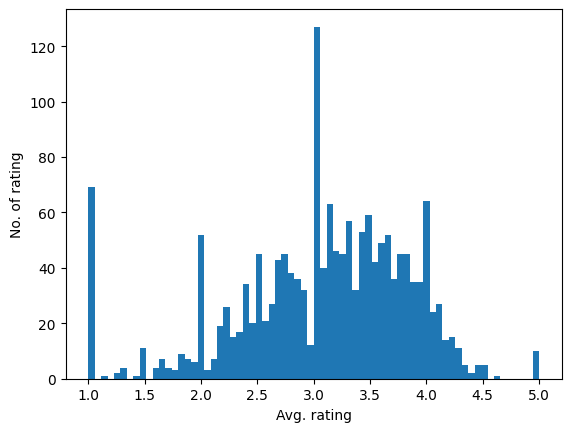

In [ ]:
# The Histogram shows that:
# The distribution is slightly right-skewed, meaning higher ratings (above 3.0) are more common than lower ratings.
# Very few movies received extremely perfect ratings (5.0).

plt.hist(temp['rating'],bins=70)
plt.xlabel('Avg. rating')
plt.ylabel('No. of rating')
plt.show()

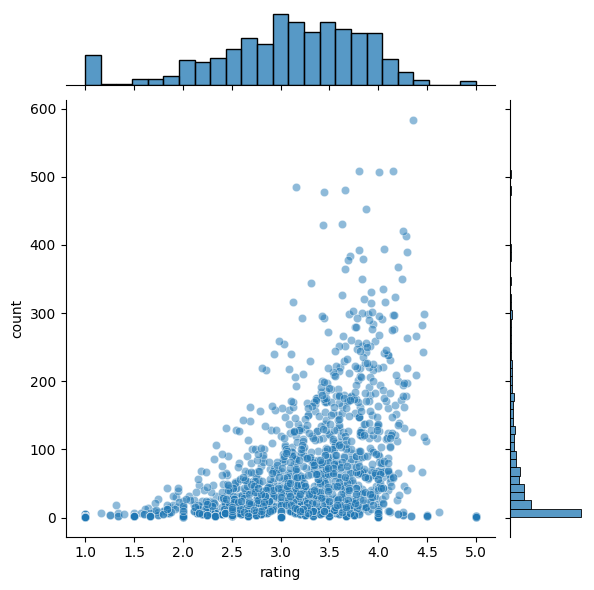

In [ ]:
# X-axis ("rating"): Represents the rating values (ranging from 1 to 5).
# Y-axis ("count"): Represents how many times each rating appears.
# Top Histogram: Shows the distribution of ratings.
# Right Histogram: Shows the distribution of count values.

# The scatter plot suggests that as the rating increases, the number of ratings also tends to increase.
# Movies with ratings around 3.5 to 4.5 have the highest counts, meaning they are the most commonly given ratings.

sns.jointplot(x = temp['rating'], y = temp['count'], data = temp, alpha = 0.5 )

# Model Building

In [ ]:
# Creating User-item utility Matrix
util_df = pd.pivot_table(data=df, values='rating', index='user_id', columns='movie_id', aggfunc='mean', fill_value=0)
util_df

# The resulting matrix (util_df) shows how users rate movies.
# Rows (user_id) → Represents users (1 to 943).
# Columns (movie_id) → Represents movies (1 to 1682).
# Values (ratings) → The actual rating a user gave to a movie (from 1 to 5).
# 0 values → "not rated" (i.e., the user has not watched or rated that movie).

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
A = util_df.to_numpy() # Converts the user-item matrix (util_df) into a NumPy array (A). This makes it easier to apply matrix operations (like, SVD).
# Normalize Ratings (Centering)
# Normalization removes bias (e.g., users who always rate movies between 3-5). It improves the performance of collaborative filtering models like SVD.
user_means = np.mean(A, axis=1, keepdims=True)
A_normalized = A - user_means

**Applies Singular Value Decomposition (SVD) to the normalized user-item matrix (A_normalized).**

SVD decomposes the matrix into three components:

𝐴
𝑛
𝑜
𝑟
𝑚
𝑎
𝑙
𝑖
𝑧
𝑒
𝑑
=
𝑈
⋅
Σ
⋅
𝑉
𝑇
A
normalized
​
 =U⋅Σ⋅V
T

U → User feature matrix (shape: (943, 943))

Sigma → Singular values (1D array of length min(943, 1682))

Vt → Movie feature matrix (shape: (1682, 1682) but transposed)

In [ ]:
U, Sigma, Vt = np.linalg.svd(A_normalized, full_matrices=False)
# We truncate SVD to only keep the top 100 singular values. This reduces the dimensionality while keeping the most important information.
k = 100
U, Sigma, Vt = U[:, :k], Sigma[:k], Vt[:k, :]

**Build the KNN Model**

Using K-Nearest Neighbors to find users similar to a target user.

U is the user latent feature matrix (from truncated SVD).

n_neighbors=10: Find 10 most similar users.

metric='cosine': Similarity is based on cosine distance (commonly used in recommender systems).



In [ ]:
# KNN-Based User Similarity
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(U)

def get_knn_recommendations(user_id, top_n=10):
    distances, indices = knn.kneighbors(U[user_id].reshape(1, -1))
    similar_users = indices.flatten()

    recommended_movies = []

    for user in similar_users:
        top_movies = np.argsort(A[user])[::-1][:top_n]
        recommended_movies.extend(top_movies)

    # Ensure only top_n unique recommendations
    recommended_movies = list(dict.fromkeys(recommended_movies))[:top_n] #Picks the top-rated movie indices. Adds them to the recommended_movies list.

    return df_item[df_item['movie_id'].isin(recommended_movies)][['movie_id', 'movie_title']]


**Matrix Factorization (ALS-style) using surprise Library**

In [ ]:
reader = Reader(rating_scale=(1, 5)) #user ratings range from 1 to 5
# Taking df_rating DataFrame and loading it into the Surprise library's expected format. Only the user_id, movie_id, and rating columns are passed.
data = Dataset.load_from_df(df_rating[['user_id', 'movie_id', 'rating']], reader)

svd = SVD() #initialize the svd model
trainset = data.build_full_trainset()
svd.fit(trainset) #trains the model on available ratings

def predict_rating(user_id, movie_id): # Given a user_id and a movie_id, it returns the predicted rating the user would give to the movie.
    return svd.predict(user_id, movie_id).est

In [ ]:
# Example Usage
user_id_to_recommend = 50
print("Top 10 KNN-Based Recommendations for User 50:")
print(get_knn_recommendations(user_id_to_recommend, top_n=10))

print("Predicted Rating for User 50 on Movie 100:", predict_rating(50, 100))

Top 10 KNN-Based Recommendations for User 50:
     movie_id                         movie_title
48         49                         I.Q. (1994)
62         63            Santa Clause, The (1994)
81         82                Jurassic Park (1993)
130       131       Breakfast at Tiffany's (1961)
142       143          Sound of Music, The (1965)
170       171                 Delicatessen (1991)
171       172     Empire Strikes Back, The (1980)
179       180               Apocalypse Now (1979)
201       202                Groundhog Day (1993)
494       495  Around the World in 80 Days (1956)
Predicted Rating for User 50 on Movie 100: 3.5595320121890426


In [ ]:
# Example Usage 2
user_id_to_recommend = 25
print("Top 10 KNN-Based Recommendations for User 25:")
print(get_knn_recommendations(user_id_to_recommend, top_n=10))

print("Predicted Rating for User 25 on Movie 200:", predict_rating(25, 200))

Top 10 KNN-Based Recommendations for User 25:
     movie_id                                     movie_title
98         99          Snow White and the Seven Dwarfs (1937)
125       126                      Spitfire Grill, The (1996)
127       128                                 Supercop (1992)
179       180                           Apocalypse Now (1979)
244       245                         Devil's Own, The (1997)
267       268                              Chasing Amy (1997)
300       301                                 In & Out (1997)
311       312  Midnight in the Garden of Good and Evil (1997)
513       514                               Annie Hall (1977)
748       749                          MatchMaker, The (1997)
Predicted Rating for User 25 on Movie 200: 4.052855623101773
